[boston 데이터셋을 활용한 집값 예측]
- 데이터셋: boston.csv
- 구현 프레임워크: Pytorch

[1] 모듈 로딩 및 데이터 준비

In [128]:
#모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchmetrics.regression import R2Score

In [129]:
torch.manual_seed(1)

device='cuda' if torch.cuda.is_available() else 'cpu'

In [130]:
data_file='../data/boston.csv'
boston_df=pd.read_csv(data_file)
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


[2] 모델 준비
- 학습 방법: 지도학습 중 회귀
- 알고리즘: 선형모델(nn.Sequential)

In [131]:
model=nn.Sequential(nn.Linear(13,10),
                    nn.ReLU(),
                    nn.Linear(10,7),
                    nn.ReLU(),
                    nn.Linear(7,5),
                    nn.ReLU(),
                    nn.Linear(5,3),
                    nn.ReLU(),
                    nn.Linear(3,1))

In [132]:
for name,param in model.named_parameters():
    print(f'[{name}] {param} \n')

[0.weight] Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013],
        [-0.1081, -0.0202, -0.0250,  0.0402, -0.0011,  0.2425,  0.0863, -0.1033,
         -0.1675, -0.0465, -0.1196, -0.0889,  0.0133],
        [ 0.1653,  0.1507, -0.2711,  0.1719,  0.0775,  0.2631,  0.1831, -0.2527,
         -0.2637, -0.1338,  0.2435, -0.0462,  0.1187],
        [-0.1289,  0.2721, -0.1173,  0.2080,  0.0033, -0.1461,  0.1426, -0.1472,
          0.0816, -0.0801, -0.0304, -0.2666, -0.1322],
        [ 0.1505, -0.0674,  0.2763,  0.2223, -0.0130, -0.1851,  0.1689,  0.0861,
         -0.1793,  0.1802,  0.1684,  0.2460, -0.1555],
        [-0.0457, -0.0054,  0.0405, -0.2105, -0.1968,  0.1509, -0.0650,  0.1355,
          0.0158,  0.0911,  0.0610,  0.1008,  0.1375],
        [-0.2569,  0.1396, -0.1950, -0.2093,  0.0169, -0.0473,  0.1629, -0.1606,
         -0.2466,  0.2018, -0.0411,  0.1560,  0.0892],
        [-0.208

[3] 최적화 인스턴스 준비

In [133]:
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습

In [134]:
feature_df=boston_df[boston_df.columns[:-1]]
target_df=boston_df[['MEDV']]

print(feature_df.shape,target_df.shape)

(506, 13) (506, 1)


In [135]:
x_train,x_test,y_train,y_test=train_test_split(feature_df,target_df,test_size=0.2,random_state=10)

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=10)

print(f'[FEATURE] TRAIN {x_train.shape}, TEST {x_test.shape}, VALIDATE {x_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VALIDATE {y_val.shape}')

[FEATURE] TRAIN (323, 13), TEST (102, 13), VALIDATE (81, 13)
[TARGET] TRAIN (323, 1), TEST (102, 1), VALIDATE (81, 1)


In [136]:
EPOCH=275
BATCH_SIZE=17
BATCH_CNT=x_train.shape[0]//BATCH_SIZE

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 275, BATCH_SIZE: 17, BATCH_CNT: 19


In [137]:
def testing(test_df,target_df):
    test_ts=torch.FloatTensor(test_df.values).to(device)
    test_target=torch.FloatTensor(target_df.values).to(device)

    with torch.no_grad():
        pre_y=model(test_ts)
        loss=F.mse_loss(pre_y,test_target)
        r2=R2Score()(pre_y,test_target)

    return loss.item(),r2

In [138]:
def training(feature_ts,target_ts,val_ts,val_target_ts):

    loss_history=[[],[]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):

        bs_loss=0
        bs_r2=0

        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end=start+BATCH_SIZE

            bsx_train=torch.FloatTensor(x_train[start:end].values).to(device)
            bsy_train=torch.FloatTensor(y_train[start:end].values).to(device)

            pre_y=model(bsx_train)

            loss=F.mse_loss(pre_y,bsy_train)
            bs_loss+=loss.item()
            bs_r2+=R2Score()(pre_y,bsy_train).item()

            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        val_loss,val_r2=testing(val_ts,val_target_ts)
        loss_history[1].append(val_loss)
        r2_history[1].append(val_r2)

        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        print(f'[{epoch}/{EPOCH}]\n TRAIN LOSS: {loss_history[0][-1]}, R2: {r2_history[0][-1]}')
        print(f'VAL LOSS: {loss_history[1][-1]}, R2: {r2_history[1][-1]}')

    return loss_history,r2_history

In [139]:
loss,r2=training(x_train,y_train,x_val,y_val)

[0/275]
 TRAIN LOSS: 255.9868716189736, R2: -3.605092399998715
VAL LOSS: 43.15632247924805, R2: 0.14746689796447754
[1/275]
 TRAIN LOSS: 90.54707256116365, R2: -0.23000878723044144
VAL LOSS: 74.11406707763672, R2: -0.46408891677856445
[2/275]
 TRAIN LOSS: 74.08773833826969, R2: -0.08332994737123188
VAL LOSS: 46.03699493408203, R2: 0.09056055545806885
[3/275]
 TRAIN LOSS: 58.16502480757864, R2: 0.24116414785385132
VAL LOSS: 37.23355484008789, R2: 0.2644684314727783
[4/275]
 TRAIN LOSS: 55.48144882603695, R2: 0.28401453557767364
VAL LOSS: 38.41042709350586, R2: 0.2412198781967163
[5/275]
 TRAIN LOSS: 52.70958468788549, R2: 0.3235540986061096
VAL LOSS: 36.52227020263672, R2: 0.27851951122283936
[6/275]
 TRAIN LOSS: 50.42005990680895, R2: 0.3476185014373378
VAL LOSS: 39.49505615234375, R2: 0.21979349851608276
[7/275]
 TRAIN LOSS: 50.45183046240555, R2: 0.32572248421217265
VAL LOSS: 38.40108871459961, R2: 0.24140429496765137
[8/275]
 TRAIN LOSS: 41.027794687371504, R2: 0.4561140537261963
VA

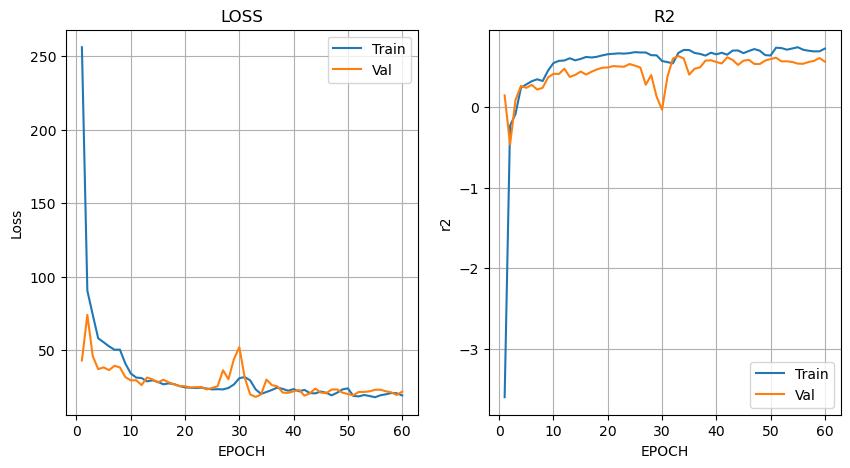

In [140]:
threshold=60
fig,axes=plt.subplots(1,2,figsize=(10,5))

axes[0].plot(range(1,threshold+1),loss[0][:threshold],label='Train')
axes[0].plot(range(1,threshold+1),loss[1][:threshold],label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,threshold+1),r2[0][:threshold],label='Train')
axes[1].plot(range(1,threshold+1),r2[1][:threshold],label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('r2')
axes[1].set_title('R2')

plt.show()